#### Import Libraries and Data

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#### Load Data

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

#### Inspecting First rows

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


#### Inspecting Last rows

In [4]:
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


#### Inspecting Random sample

In [5]:
df.sample(7)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
7401,None,297.79,0.00,0.0,1,Clear,sky is clear,2013-07-03 11:00:00,5123
14120,None,284.75,0.87,0.0,40,Mist,mist,2014-05-08 09:00:00,5048
19812,None,271.76,0.00,0.0,1,Clear,sky is clear,2015-12-03 19:00:00,3421
33696,None,290.48,0.00,0.0,90,Thunderstorm,thunderstorm with light rain,2017-05-17 02:00:00,287
2710,None,260.68,0.00,0.0,1,Mist,mist,2013-01-06 08:00:00,1478
19746,None,272.65,0.00,0.0,90,Mist,mist,2015-11-30 10:00:00,3930
9456,None,277.07,0.00,0.0,0,Clear,Sky is Clear,2013-10-14 02:00:00,291


#### Inspecting Data types

In [6]:
df.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

#### Inspecting Rows and columns

In [7]:
df.shape

(48204, 9)

#### Data Cleaing

In [9]:
# Convert date_time to datetime
df['date_time'] = pd.to_datetime(df['date_time'])

In [11]:
# Handle missing/inconsistent values (e.g., 'None' in holiday to 'No Holiday')
df['holiday'] = df['holiday'].replace('None', 'No Holiday')
df['is_holiday'] = (df['holiday'] != 'No Holiday').astype(int)

# Convert temp from Kelvin to Celsius 
df['temp_Celcius'] = df['temp'] - 273.15
df = df.drop('temp', axis = 1)

In [12]:
# Weather: keeping only the high-level category (weather_main)
df = pd.get_dummies(df,
                    columns=['weather_main'],
                    drop_first=True, 
                    prefix='weather')

In [13]:
# Cyclic encoding of time 
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

In [14]:
df_backup = df.copy()

In [15]:
cols_to_drop = ['holiday', 'weather_description', 'hour', 'date_time']
df = df.drop(columns = cols_to_drop)

In [17]:
# Final dataset check
print("Dataset shape: ", df.shape)
print("\nColumns after feature engineering: ", df.columns.tolist())
print("\nFirst 5 rows after preprocessing: ")
df.head()

Dataset shape:  (48204, 21)

Columns after feature engineering:  ['rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'temp_Celcius', 'is_holiday', 'weather_Clouds', 'weather_Drizzle', 'weather_Fog', 'weather_Haze', 'weather_Mist', 'weather_Rain', 'weather_Smoke', 'weather_Snow', 'weather_Squall', 'weather_Thunderstorm', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'is_weekend']

First 5 rows after preprocessing: 


,rain_1h,snow_1h,clouds_all,traffic_volume,temp_Celcius,is_holiday,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,...,weather_Rain,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,dayofweek,month,hour_sin,hour_cos,is_weekend
0,0.0,0.0,40,5545,15.13,0,1,0,0,0,...,0,0,0,0,0,1,10,7.071068e-01,-0.707107,0
1,0.0,0.0,75,4516,16.21,0,1,0,0,0,...,0,0,0,0,0,1,10,5.000000e-01,-0.866025,0
2,0.0,0.0,90,4767,16.43,0,1,0,0,0,...,0,0,0,0,0,1,10,2.588190e-01,-0.965926,0
3,0.0,0.0,90,5026,16.98,0,1,0,0,0,...,0,0,0,0,0,1,10,1.224647e-16,-1.000000,0
4,0.0,0.0,75,4918,17.99,0,1,0,0,0,...,0,0,0,0,0,1,10,-2.588190e-01,-0.965926,0


#### Descriptive Statistics

In [20]:
numeric_cols = ['temp_Celcius', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

desc_stats = df[numeric_cols].describe().T
desc_stats['variance'] = df[numeric_cols].var()
desc_stats['dispersion_index'] = desc_stats['variance'] / desc_stats['mean']
desc_stats.round(3)

,count,mean,std,min,25%,50%,75%,max,variance,dispersion_index
temp_Celcius,48204.0,8.056,13.338,-273.15,-0.99,9.3,18.656,36.92,177.908,22.084
rain_1h,48204.0,0.334,44.789,0.00,0.00,0.0,0.000,9831.30,2006.066,6001.444
snow_1h,48204.0,0.000,0.008,0.00,0.00,0.0,0.000,0.51,0.000,0.300
clouds_all,48204.0,49.362,39.016,0.00,1.00,64.0,90.000,100.00,1522.229,30.838
traffic_volume,48204.0,3259.818,1986.861,0.00,1193.00,3380.0,4933.000,7280.00,3947615.324,1210.992


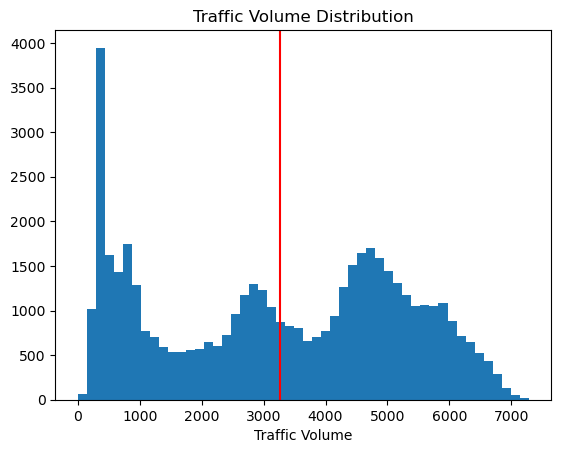

In [21]:
plt.hist(df['traffic_volume'], bins=50)
plt.axvline(df['traffic_volume'].mean(), color='red')
plt.xlabel('Traffic Volume')
plt.title('Traffic Volume Distribution')
plt.show()

In [22]:
dispersion = df['traffic_volume'].var() / df['traffic_volume'].mean()
print(f"\nDispersion Index (Variance/Mean) = {dispersion:.3f}")


Dispersion Index (Variance/Mean) = 1210.992


In [23]:
weather_cols = [col for col in df.columns if col.startswith('weather_')]

predictors = ['temp_Celcius', 'rain_1h', 'snow_1h', 'clouds_all',
              'is_holiday', 'is_weekend', 
              'hour_sin', 'hour_cos'] + weather_cols

X = df[predictors]
y = df['traffic_volume']

# Add constant
X = sm.add_constant(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(df['hour_sin'], bins=24))

print(f"Training samples  : {len(y_train):,}")
print(f"Test samples      : {len(y_test):,}")
print(f"Total predictors  : {len(predictors)} → {predictors}")

Training samples  : 38,563
Test samples      : 9,641
Total predictors  : 18 → ['temp_Celcius', 'rain_1h', 'snow_1h', 'clouds_all', 'is_holiday', 'is_weekend', 'hour_sin', 'hour_cos', 'weather_Clouds', 'weather_Drizzle', 'weather_Fog', 'weather_Haze', 'weather_Mist', 'weather_Rain', 'weather_Smoke', 'weather_Snow', 'weather_Squall', 'weather_Thunderstorm']


In [24]:
poisson_model = GLM(y_train, X_train, family=families.Poisson())
poisson_res = poisson_model.fit(maxiter=100)
print(poisson_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         traffic_volume   No. Observations:                38563
Model:                            GLM   Df Residuals:                    38544
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1102e+07
Date:                Fri, 05 Dec 2025   Deviance:                   2.1833e+07
Time:                        16:10:02   Pearson chi2:                 2.18e+07
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.0449 

In [25]:
nb_model = GLM(y_train, X_train, family=families.NegativeBinomial(alpha=61.55))
nb_res = nb_model.fit(maxiter=200)
print(nb_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         traffic_volume   No. Observations:                38563
Model:                            GLM   Df Residuals:                    38544
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.6087e+05
Date:                Fri, 05 Dec 2025   Deviance:                       197.67
Time:                        16:10:16   Pearson chi2:                     188.
No. Iterations:                    11   Pseudo R-squ. (CS):           0.005734
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.0190 

In [26]:
X_null_train = sm.add_constant(np.ones(len(y_train)))
poisson_null = GLM(y_train, X_null_train, family=families.Poisson()).fit()
nb_null      = GLM(y_train, X_null_train, family=families.NegativeBinomial(alpha=61.55)).fit()

In [27]:
def mcfadden_r2(full, null):
    return 1 - (full.llf / null.llf)

poisson_r2 = mcfadden_r2(poisson_res, poisson_null)
nb_r2      = mcfadden_r2(nb_res, nb_null)

In [28]:
results_df = pd.DataFrame({
    'Model': ['Poisson', 'Negative Binomial'],
    'AIC'  : [poisson_res.aic, nb_res.aic],
    'McFadden R²': [poisson_r2, nb_r2],
    'Dispersion (χ²/df)': [
        poisson_res.pearson_chi2 / poisson_res.df_resid,
        nb_res.pearson_chi2 / nb_res.df_resid
    ],
    'Log-Likelihood': [poisson_res.llf, nb_res.llf]
}).round(4)

print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)
print(results_df)
print("="*70)
print(f"→ NEGATIVE BINOMIAL WINS by {poisson_res.aic - nb_res.aic:,.0f} AIC points!")


FINAL MODEL COMPARISON
               Model           AIC  McFadden R²  Dispersion (χ²/df)  \
0            Poisson  2.220346e+07       0.6016            566.8163   
1  Negative Binomial  9.217704e+05       0.0002              0.0049   

   Log-Likelihood  
0   -1.110171e+07  
1   -4.608662e+05  
→ NEGATIVE BINOMIAL WINS by 21,281,689 AIC points!


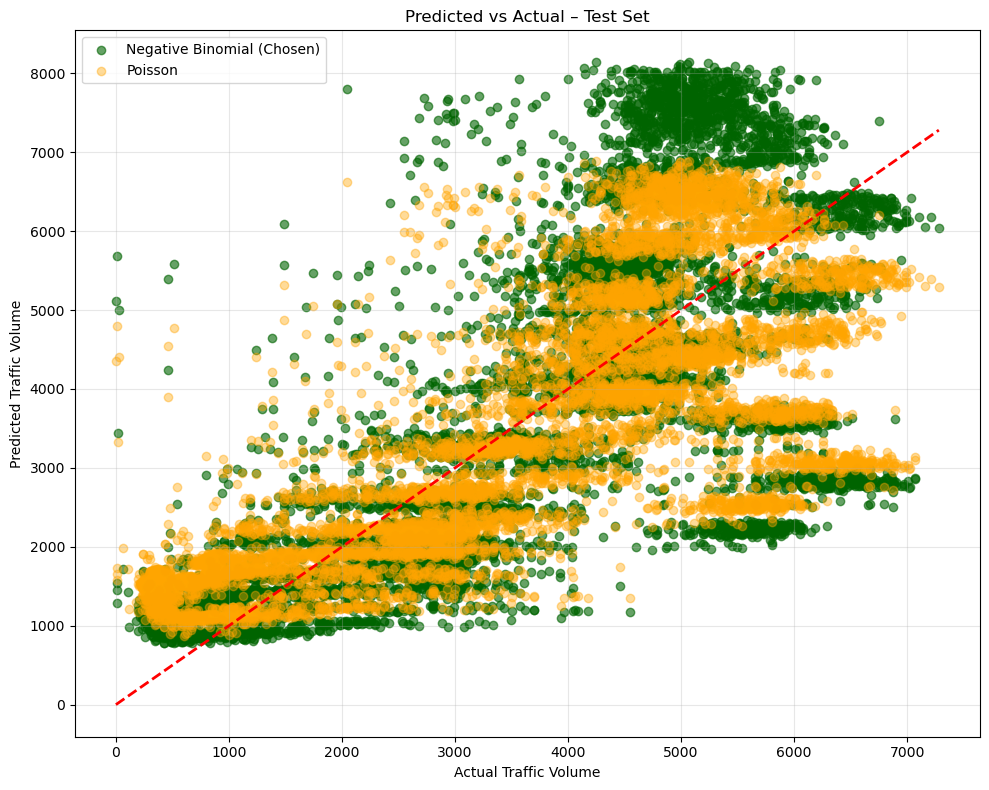

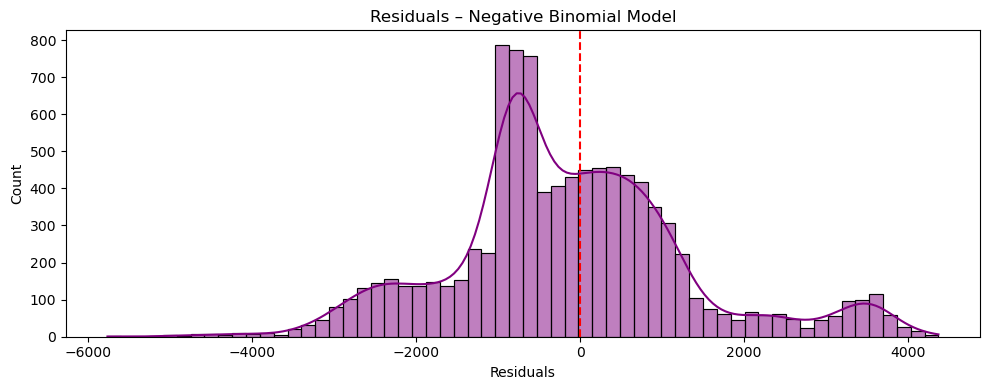

In [29]:
# Predictions on test set
pred_poisson = poisson_res.predict(X_test)
pred_nb      = nb_res.predict(X_test)

# Predicted vs Actual
plt.figure(figsize=(10,8))
plt.scatter(y_test, pred_nb, alpha=0.6, label='Negative Binomial (Chosen)', color='darkgreen')
plt.scatter(y_test, pred_poisson, alpha=0.4, label='Poisson', color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Traffic Volume')
plt.ylabel('Predicted Traffic Volume')
plt.title('Predicted vs Actual – Test Set')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pred_vs_actual_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Residuals of best model (NB)
residuals_nb = y_test - pred_nb
plt.figure(figsize=(10,4))
sns.histplot(residuals_nb, kde=True, bins=60, color='purple')
plt.title('Residuals – Negative Binomial Model')
plt.xlabel('Residuals')
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.savefig('residuals_nb_final.png', dpi=300, bbox_inches='tight')
plt.show()